# Conditional GAN for generation

## Data preprocessing

For this demonstration, the dataset is restricted to events with **thrown photon energies between 1.0 GeV and 2.0 GeV**.  
This limited range serves two purposes:

1. **Computational Feasibility:**  
   Restricting to a narrow energy window ensures that the GAN can be trained efficiently — even on CPU — within a reasonable number of epochs.  
   It also reduces the overall dynamic range of shower intensities, simplifying the conditional learning task.

2. **Controlled Conditioning:**  
   By fixing a limited energy range, the model focuses on learning **fine-grained variations in shower shape** rather than global scaling with energy.  
   This allows clearer interpretation of the conditioning effect and better visual inspection of generated patterns.

### Hit Energy Threshold

Because a GAN learns to generate *physically plausible* but not *pixel-by-pixel identical* hit patterns, a small energy threshold is applied to define realistic cell occupancies.  
In particular, we apply a **per-cell energy cut of 0.05 GeV (50 MeV)** when evaluating or visualizing generated showers:

$$
E_{\text{cell}} \ge 0.05 \, \text{GeV}
$$

This threshold reflects the approximate detection sensitivity of the Forward Calorimeter and helps eliminate numerical noise or unphysical low-level fluctuations in the generated images.

By doing so, the comparison between real and generated showers focuses on meaningful energy deposits — i.e., those that would actually produce measurable detector responses — rather than on statistical pixel noise or reconstruction artifacts.

### Practical Implication

With these cuts:
- The GAN trains faster and more stably due to reduced input variance.  
- Visual and quantitative metrics (e.g., occupancy, E1/E9) become more physically interpretable.  
- Generated showers correspond to realistic FCAL responses within the 1–2 GeV photon energy regime, making them ideal for illustrating the principles of **conditional generative modeling in calorimeter simulation**.


In [1]:
%pip install h5py scikit-learn torch torchvision tqdm safetensors autograd torchmetrics > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from urllib.parse import urlparse
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    """Custom TQDM progress bar for urllib downloads."""
    def update_to(self, blocks=1, block_size=1, total_size=None):
        """
        Update the progress bar.

        Args:
            blocks (int): Number of blocks transferred so far.
            block_size (int): Size of each block (in bytes).
            total_size (int, optional): Total size of the file (in bytes).
        """
        if total_size is not None:
            self.total = total_size
        self.update(blocks * block_size - self.n)


def download(url, target_dir):
    """
    Download a file from a URL into the target directory with progress display.

    Args:
        url (str): Direct URL to the file.
        target_dir (str): Directory to save the file.

    Returns:
        str: Path to the downloaded (or existing) file.
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Infer the filename from the URL
    filename = os.path.basename(urlparse(url).path)
    local_path = os.path.join(target_dir, filename)

    # If file already exists, skip download
    if os.path.exists(local_path):
        print(f"✅ File already exists: {local_path}")
        return local_path

    # Download with progress bar
    print(f"⬇️  Downloading {filename} from {url}")

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
        urllib.request.urlretrieve(url, filename=local_path, reporthook=t.update_to)

    print(f"✅ Download complete: {local_path}")
    return local_path

In [3]:

dataset_url = "https://huggingface.co/datasets/AI4EIC/DNP2025-tutorial/resolve/main/formatted_dataset/CNN4FCAL_GUN_PATCHSIZE_11.h5"
data_dir = "data"
dataset_path = download(dataset_url, data_dir)



✅ File already exists: data/CNN4FCAL_GUN_PATCHSIZE_11.h5


```{note}
This is exactly the same as in [CNN for Regression](./02-cnn-regression.ipynb). 
```

We are using the same `.h5` dataset for regression. when we process it, We will be simply selecting out photons only to perform our training

### Step 1: Open and Inspect the `.h5` File

We can open the dataset and confirm whats inside it


In [4]:
import h5py, numpy as np
with h5py.File(dataset_path, "r") as f:
    print("✅ Datasets available:", list(f.keys()))
    print("🔍 patches shape:", f["patches"].shape)
    print("🔍 labels shape:", f["label"].shape)

✅ Datasets available: ['label', 'patches', 'showerE', 'thrownE']
🔍 patches shape: (814151, 11, 11)
🔍 labels shape: (814151,)


### Step 2: Create a Custom PyTorch Dataset

This dataset will:

* Read directly from the `.h5` file
* Optionally we can apply normalization in the form of transformation

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np # Import numpy

class FCALPatchPhotonDataset(Dataset):
    def __init__(self, h5_path, indices=None, transform=None, thrownNormalize=True, minthrownE = 0.1, maxthrownE = 4.0):
        """
        Parameters
        ----------
        h5_path : str
            Path to the HDF5 file.
        indices : list or np.ndarray, optional
            Subset of indices to use (for train/val/test split).
        transform : callable, optional
            Optional transform to apply to each patch.
        """
        # Open the file handle here and keep it open
        self.h5_path = h5_path
        self.file = h5py.File(self.h5_path, "r")
        self.indices = indices
        self.transform = transform
        self.minthrownE = minthrownE  # GeV
        self.maxthrownE = maxthrownE  # GeV

        # Assign datasets directly from the file handle
        self.length = len(self.file["label"])
        self.labels = np.array(self.file["label"], dtype=np.int64)
        self.labels = self.labels[self.indices if self.indices is not None else slice(None)]
        self.patches = np.array(self.file["patches"], dtype=np.float32)
        self.patches = self.patches[self.indices] if self.indices is not None else self.patches
        self.showerE = np.array(self.file["showerE"], dtype=np.float32)
        self.showerE = self.showerE[self.indices if self.indices is not None else slice(None)]
        self.thrownE = np.array(self.file["thrownE"], dtype=np.float32)
        self.thrownE = self.thrownE[self.indices if self.indices is not None else slice(None)] 
        self.file.close()

        # lets select only photons and select photons only with showerE >= 1  <= 2
        self.photon_indices = np.where((self.labels == 1) & (self.thrownE >= self.minthrownE) & (self.thrownE <= self.maxthrownE))
        self.length = len(self.photon_indices)
        
        self.labels = self.labels[self.photon_indices]
        self.patches = self.patches[self.photon_indices]
        self.showerE = self.showerE[self.photon_indices]
        self.thrownE = self.thrownE[self.photon_indices]

        if thrownNormalize:
            self.thrownE = ( self.thrownE - self.minthrownE ) / ( self.maxthrownE - self.minthrownE )  # Normalize 


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Handle subset indices

        # Access data directly from the assigned attributes
        patch = self.patches[idx]
        label = self.labels[idx]
        showerE = self.showerE[idx]
        thrownE = self.thrownE[idx]

        # Optional transform
        if self.transform:
            patch = self.transform(patch)

        # Convert to torch tensors
        patch = torch.from_numpy(patch).unsqueeze(0)  # (1, 11, 11)
        return patch, label, showerE, thrownE

### Step 3: Create Dataset and DataLoader Objects

The entire dataset will be used for training here. Let us normalize each of the images with the total energy of all the hits in the shower

In [ ]:

MIN_THROWN_E = 1.0  # GeV
MAX_THROWN_E = 2.0  # GeV
ENERGY_SCALE  = 0.05    # GeV (for global log scaling)
MIN_ENERGY_THRESH = 0.05 # GeV We will not retain pixels with energy less than this
CLIP_MAX      = 2.0     # GeV per cell clamp for scaling
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP       = (DEVICE == "cuda")   # automatic mixed precision only on CUDA
BATCH_SIZE    = 512
NUM_WORKERS = 1
pin = (DEVICE == "cuda")

def log_global_norm(W, e0=ENERGY_SCALE, emax=CLIP_MAX):
    # Keep everything float32 to avoid silent upcasts to float64
    W    = W.clip(min=0).astype(np.float32, copy=False)
    e0   = np.float32(e0)
    emax = np.float32(emax)
    Z = np.log1p(W / e0).astype(np.float32, copy=False)
    Z /= np.log1p(emax / e0).astype(np.float32, copy=False)
    np.clip(Z, 0.0, 1.0, out=Z)
    Z = 2.0 * Z - 1.0  # now in [-1,1]
    return Z  # float32

def inv_log_global_norm(Z, e0=ENERGY_SCALE, emax=CLIP_MAX):
    # Z in [-1, 1]  ->  W in GeV
    Z01 = (Z + 1.0) / 2.0
    return e0 * np.expm1(Z01 * np.log1p(emax / e0))

def inv_log_global_norm_torch(Z, e0=ENERGY_SCALE, emax=CLIP_MAX):
    # Z in [-1, 1]  ->  W in GeV
    Z01 = (Z + 1.0) / 2.0
    e0_t   = torch.as_tensor(e0,   dtype=Z01.dtype, device=Z01.device)
    emax_t = torch.as_tensor(emax, dtype=Z01.dtype, device=Z01.device)
    return e0_t * torch.expm1(Z01 * torch.log1p(emax_t / e0_t))
def normalize_patch(patch):
    # Example normalization to total energy = 1
    total = np.sum(patch)
    return patch / total if total > 0 else patch

train_ds = FCALPatchPhotonDataset(dataset_path,transform=log_global_norm, minthrownE=MIN_THROWN_E, maxthrownE=MAX_THROWN_E)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True
                          )


In [26]:
len(train_ds), len(train_loader)

(434845, 850)

Batch shape: torch.Size([512, 1, 11, 11])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])
showerE: tensor([0.3325, 3.5390, 2.3319, 0.4360, 0.5163, 0.6927, 2.1972, 1.8692])
thrownE: tensor([0.0698, 0.8418, 0.5843, 0.0888, 0.0891, 0.1498, 0.5441, 0.3809])


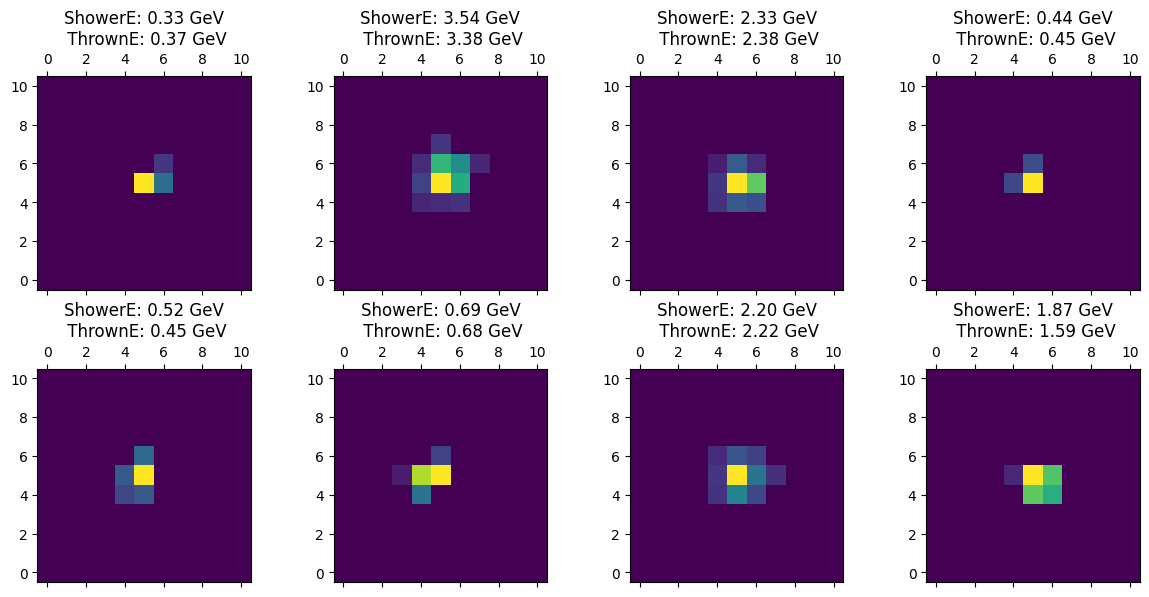

In [27]:
# lets check a few samples

patches, labels, showerE, thrownE = next(iter(train_loader))
print("Batch shape:", patches.shape)    # (B, 1, 11, 11)
print("Labels:", labels[:8])
print("showerE:", showerE[:8])
print("thrownE:", thrownE[:8])

# Lets visualize a few patches
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.matshow(patches[i, 0].numpy(), cmap='viridis', origin='lower')
    thE = thrownE[i].item() * (MAX_THROWN_E - MIN_THROWN_E) + MIN_THROWN_E
    ax.set_title(f'ShowerE: {showerE[i].item():.2f} GeV\n ThrownE: {thE:.2f} GeV')
    #ax.axis('off')
plt.tight_layout()
plt.show()

### Step 4: Diagnostic plots

Let us make a few diagnostic plots. We will be using these plots for visual comparison between generated samples and true distributions.

In [28]:
def compute_patch_metrics(patches: torch.Tensor, thrownE: torch.Tensor, patch_size = 11, e_threshold = MIN_ENERGY_THRESH) -> dict:
    """
    Compute metrics for a batch of patches.

    Parameters
    ----------
    patches : torch.Tensor
        Tensor of shape (B, 1, 11, 11) representing the patches.
    thrownE : torch.Tensor
        Tensor of shape (B,) representing the thrown energies.

    Returns
    -------
    dict
        Dictionary containing numHits, rows, cols, energies, total energy (sum), max cell energy, E1/E9 ratio, E9/E25 ratio, and energy-weighted centroid for each patch.
    """
    
    B = patches.shape[0]
    assert patches.shape == (B, 1, patch_size, patch_size)
    assert thrownE.shape == (B,)

    # Remove channel dimension
    patches = patches.squeeze(1)  # (B, 11, 11)

    # Number of hits (cells with energy > 0.05 GeV)
    patches = patches * (patches > e_threshold)  # Zero out cells below threshold
    numHits = (patches > 0).sum(dim=(1, 2))  # (B,)

    # Row and column indices of hits
    _, rows, cols = torch.nonzero(patches > 0, as_tuple=True)  # (N_hits,), (N_hits,)
    hit_batch_indices = rows // patch_size  # Determine which batch each hit belongs to
    rows = rows %   patch_size
    cols = cols % patch_size

    # Energies of hits
    energies = patches[patches > 0]  # (N_hits,)

    # Total energy in each patch
    total_energy = patches.sum(dim=(1, 2))  # (B,)

    # Max cell energy in each patch
    max_cell_energy, _ = patches.view(B, -1).max(dim=1)  # (B,)

    # E1/E9 ratio
    e1 = max_cell_energy  # (B,)
    e9 = torch.zeros(B, device=patches.device)  # (B,)
    for b in range(B):
        if numHits[b] > 0:
            max_idx = torch.argmax(patches[b])
            r, c = divmod(max_idx.item(), patch_size)
            r_min = max(r - 1, 0)
            r_max = min(r + 2, patch_size)
            c_min = max(c - 1, 0)
            c_max = min(c + 2, patch_size)
            e9[b] = patches[b, r_min:r_max, c_min:c_max].sum()
    e1_e9_ratio = e1 / e9.clamp(min=1e-6)  # Avoid division by zero

    # E9/E25 ratio
    e25 = torch.zeros(B, device=patches.device)  # (B,)
    for b in range(B):
        if numHits[b] > 0:
            max_idx = torch.argmax(patches[b])
            r, c = divmod(max_idx.item(), patch_size)
            r_min = max(r - 2, 0)
            r_max = min(r + 3, patch_size)
            c_min = max(c - 2, 0)
            c_max = min(c + 3, patch_size)
            e25[b] = patches[b, r_min:r_max, c_min:c_max].sum()
    e9_e25_ratio = e9 / e25.clamp(min=1e-6)  # Avoid division by zero
    # Energy-weighted centroid
    centroids = []
    for b in range(B):
        if total_energy[b] > 0:
            r_indices = torch.arange(patch_size, device=patches.device).view(1, -1).expand(11, 11)
            c_indices = torch.arange(patch_size, device=patches.device).view(-1, 1).expand(11, 11)
            weighted_r = (patches[b] * r_indices).sum() / total_energy[b]
            weighted_c = (patches[b] * c_indices).sum() / total_energy[b]
            centroids.append((weighted_r.item(), weighted_c.item()))
        else:
            centroids.append((-1.0, -1.0))  # Indicate no hits with -1
    centroids = np.array(centroids)  # (B, 2)
    return {
        "numHits": numHits.cpu().numpy(),
        "rows": rows.cpu().numpy(),
        "cols": cols.cpu().numpy(),
        "energies": energies.cpu().numpy(),
        "total_energy": total_energy.cpu().numpy(),
        "max_cell_energy": max_cell_energy.cpu().numpy(),
        "e1_e9_ratio": e1_e9_ratio.cpu().numpy(),
        "e9_e25_ratio": e9_e25_ratio.cpu().numpy(),
        "centroids": centroids
    }
    

def plot_patch_metrics(metrics: dict, title = "Patch Metrics", save_path = None):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(4, 3, figsize=(15, 15))
    
    axs[0, 0].hist(metrics["numHits"], bins=30, color='blue', alpha=0.7)
    axs[0, 0].set_title("Number of Hits per Patch")
    axs[0, 0].set_xlabel("Number of Hits")
    axs[0, 0].set_ylabel("Frequency")

    axs[0, 1].hist(metrics["total_energy"], bins=100, range = (0., 4.0), color='green', alpha=0.7)
    axs[0, 1].set_title("Total Energy per Patch")
    axs[0, 1].set_xlabel("Total Energy (GeV)")
    axs[0, 1].set_ylabel("Frequency")

    axs[0, 2].hist(metrics["max_cell_energy"], bins=50, range=(0., 2.0), color='red', alpha=0.7)
    axs[0, 2].set_title("Max Cell Energy per Patch")
    axs[0, 2].set_xlabel("Max Cell Energy (GeV)")
    axs[0, 2].set_ylabel("Frequency")

    axs[1, 0].hist(metrics["e1_e9_ratio"], bins=100, range=(0, 1.0),color='purple', alpha=0.7)
    axs[1, 0].set_title("E1/E9 Ratio")
    axs[1, 0].set_xlabel("E1/E9")
    axs[1, 0].set_ylabel("Frequency")

    axs[1, 1].hist(metrics["e9_e25_ratio"], bins=100, range=(0, 1.0),color='orange', alpha=0.7)
    axs[1, 1].set_title("E9/E25 Ratio")
    axs[1, 1].set_xlabel("E9/E25")
    axs[1, 1].set_ylabel("Frequency")
    # make y log scale
    axs[1, 1].set_yscale('log')

    centroids = metrics["centroids"]
    axs[1, 2].hist(centroids[:, 0], bins=50, color='purple', alpha=0.7)
    axs[1, 2].set_title("Energy-weighted Centroids (along Row)")
    axs[1, 2].set_xlabel("Rows")
    axs[1, 2].set_ylabel("Frequency")
    
    axs[2, 0].hist(centroids[:, 1], bins=50, color='cyan', alpha=0.7)
    axs[2, 0].set_title("Energy-weighted Centroids (along Column)")
    axs[2, 0].set_xlabel("Column Index")
    axs[2, 0].set_ylabel("Frequency")

    axs[2, 1].hist(metrics["rows"], bins=11, range=(0, 11), color='cyan', alpha=0.7)
    axs[2, 1].set_title("Hit Row Indices")
    axs[2, 1].set_xlabel("Row Index")
    axs[2, 1].set_ylabel("Frequency")

    axs[2, 2].hist(metrics["cols"], bins=11, range=(0, 11), color='magenta', alpha=0.7)
    axs[2, 2].set_title("Hit Column Indices")
    axs[2, 2].set_xlabel("Column Index")
    axs[2, 2].set_ylabel("Frequency")
    
    axs[3, 0].hist(metrics["energies"], bins=200, range = (0., 2.), color='brown', alpha=0.7)
    axs[3, 0].set_title("Hit Cell Energies")
    axs[3, 0].set_xlabel("Cell Energy (GeV)")
    axs[3, 0].set_ylabel("Frequency")
    # make it log y
    axs[3, 0].set_yscale('log')
    
    # lets switch off the last two subplots
    axs[3, 1].axis('off')
    axs[3, 2].axis('off')
    
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def compare_plot(generator_metrics: dict, true_patch_metrics: dict, save_path = None):
    import matplotlib.pyplot as plt
    

    fig, axs = plt.subplots(4, 3, figsize=(15, 15))
    
    # Lets make sure the histograms are not filled but has two patterns for linestyle and color is blue and red
    axs[0, 0].hist(generator_metrics["numHits"], bins=30, color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[0, 0].hist(true_patch_metrics["numHits"], bins=30, color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[0, 0].set_title("Number of Hits per Patch")
    axs[0, 0].set_xlabel("Number of Hits")
    axs[0, 0].set_ylabel("Frequency")
    axs[0, 0].legend()
    
    axs[0, 1].hist(generator_metrics["total_energy"], bins=100, range = (0., 4.0), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[0, 1].hist(true_patch_metrics["total_energy"], bins=100, range = (0., 4.0), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[0, 1].set_title("Total Energy per Patch")
    axs[0, 1].set_xlabel("Total Energy (GeV)")
    axs[0, 1].set_ylabel("Frequency")
    axs[0, 1].legend()
    
    axs[0, 2].hist(generator_metrics["max_cell_energy"], bins=50, range=(0., 2.0), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[0, 2].hist(true_patch_metrics["max_cell_energy"], bins=50, range=(0., 2.0), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[0, 2].set_title("Max Cell Energy per Patch")
    axs[0, 2].set_xlabel("Max Cell Energy (GeV)")
    axs[0, 2].set_ylabel("Frequency")
    axs[0, 2].legend()
    axs[1, 0].hist(generator_metrics["e1_e9_ratio"], bins=100, range=(0, 1.0),color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[1, 0].hist(true_patch_metrics["e1_e9_ratio"], bins=100, range=(0, 1.0),color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[1, 0].set_title("E1/E9 Ratio")
    axs[1, 0].set_xlabel("E1/E9")
    axs[1, 0].set_ylabel("Frequency")
    axs[1, 0].legend()
    
    axs[1, 1].hist(generator_metrics["e9_e25_ratio"], bins=100, range=(0, 1.0),color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[1, 1].hist(true_patch_metrics["e9_e25_ratio"], bins=100, range=(0, 1.0),color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[1, 1].set_title("E9/E25 Ratio")
    axs[1, 1].set_xlabel("E9/E25")
    axs[1, 1].set_ylabel("Frequency")
    axs[1, 1].set_yscale('log')
    axs[1, 1].legend()
    
    gen_centroids = generator_metrics["centroids"]
    disc_centroids = true_patch_metrics["centroids"]
    axs[1, 2].hist(gen_centroids[:, 0], bins=50, color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[1, 2].hist(disc_centroids[:, 0], bins=50, color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[1, 2].set_title("Energy-weighted Centroids (along Row)")
    axs[1, 2].set_xlabel("Rows")
    axs[1, 2].set_ylabel("Frequency")
    axs[1, 2].legend()
    
    axs[2, 0].hist(gen_centroids[:, 1], bins=50, color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[2, 0].hist(disc_centroids[:, 1], bins=50, color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[2, 0].set_title("Energy-weighted Centroids (along Column)")
    axs[2, 0].set_xlabel("Column Index")
    axs[2, 0].set_ylabel("Frequency")
    axs[2, 0].legend()
    
    axs[2, 1].hist(generator_metrics["rows"], bins=11, range=(0, 11), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[2, 1].hist(true_patch_metrics["rows"], bins=11, range=(0, 11), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[2, 1].set_title("Hit Row Indices")
    axs[2, 1].set_xlabel("Row Index")
    axs[2, 1].set_ylabel("Frequency")
    axs[2, 1].legend()
    
    axs[2, 2].hist(generator_metrics["cols"], bins=11, range=(0, 11), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[2, 2].hist(true_patch_metrics["cols"], bins=11, range=(0, 11), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[2, 2].set_title("Hit Column Indices")
    axs[2, 2].set_xlabel("Column Index")
    axs[2, 2].set_ylabel("Frequency")
    axs[2, 2].legend()
    
    axs[3, 0].hist(generator_metrics["energies"], bins=200, range = (0., 2.), color='blue', alpha=0.5, histtype='step', label='Generator')
    axs[3, 0].hist(true_patch_metrics["energies"], bins=200, range = (0., 2.), color='red', alpha=0.5, histtype='step', label='True Showers')
    axs[3, 0].set_title("Hit Cell Energies")
    axs[3, 0].set_xlabel("Cell Energy (GeV)")
    axs[3, 0].set_ylabel("Frequency")
    axs[3, 0].set_yscale('log')
    axs[3, 0].legend()
    
    # lets switch off the last two subplots
    axs[3, 1].axis('off')
    axs[3, 2].axis('off')
    
    plt.suptitle("Generated vs True Showers Patch Metrics", fontsize=16)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

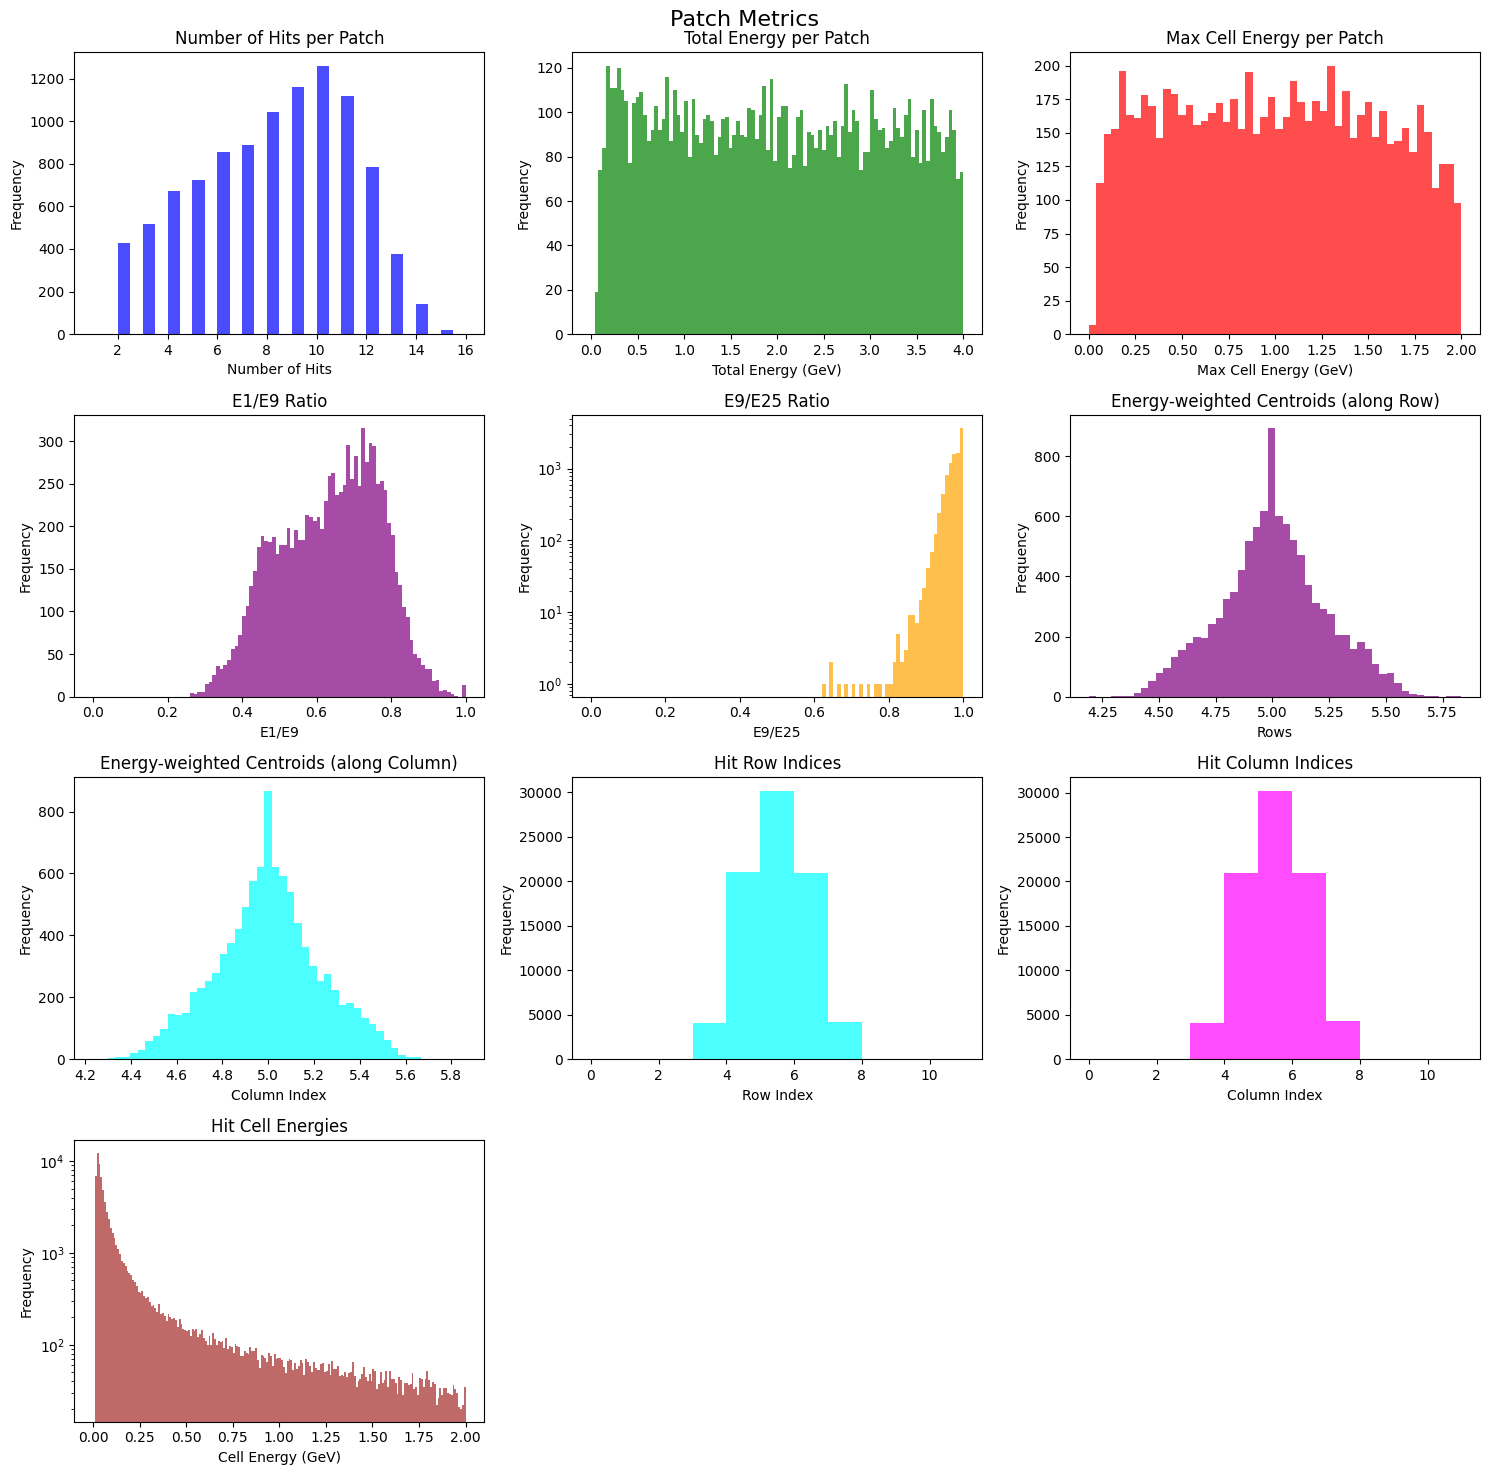

In [29]:
num_samples = 10_000
# lets randomly sample 10k patches from the dataset
indices = np.random.choice(len(train_ds), size=num_samples, replace=False)
patches = torch.from_numpy(train_ds.patches[indices]).unsqueeze(1)  # (N, 1, 11, 11)
thrownE = torch.from_numpy(train_ds.thrownE[indices])  # (N,)
patches_metrics = compute_patch_metrics(patches, thrownE)
plot_patch_metrics(patches_metrics)

## GAN architecture

The architecture implemented here is a **conditional Wasserstein GAN with Gradient Penalty (WGAN-GP)**, designed for fast simulation of calorimeter hit patterns conditioned on thrown particle energy. The goal is to learn a smooth mapping between the underlying particle-level features (e.g., thrown energy) and the corresponding spatial energy depositions (pixel maps) in the Forward Calorimeter.

### Generator Network

The **Generator (G)** learns to map a random latent vector `z` (sampled from a Gaussian prior) and a conditioning vector `e` (normalized thrown energy) into a realistic hit map of dimension *11×11*. The conditioning is incorporated via **Feature-wise Linear Modulation (FiLM)** layers, which apply learned affine transformations to intermediate feature maps based on the conditioning input.  

- The FiLM layers effectively “steer” the generator’s internal activations so that the generated pattern corresponds to the desired physical energy.  
- Upsampling is performed progressively using bilinear interpolation followed by convolution and FiLM modulation.  
- The output is a single-channel calorimeter image normalized to the range [-1, 1].

This structure ensures that the generator not only learns realistic spatial correlations but also remains responsive to changes in physical conditions (energy, and later possibly $\theta$ and $\phi$).

### Discriminator Network

The **Discriminator (D)** acts as an energy-conditioned critic. It receives both the calorimeter image and the conditioning vector, and evaluates a scalar "realness" score without a sigmoid activation — consistent with the Wasserstein formulation.  

- The image is passed through a sequence of spectrally normalized convolutional layers, producing compact latent representations.  
- The conditioning vector is embedded through a linear projection layer and combined with the image features using an inner product — a technique known as **projection discrimination**.  
- This allows the discriminator to evaluate not only the realism of the image but also its consistency with the given energy condition.

The discriminator’s score hence represents how well the generated image lies on the true data manifold for that particular physical condition.

In [ ]:
import torch
import torch.nn as nn
from safetensors.torch import save_file
from tqdm import tqdm
import numpy as np
from contextlib import nullcontext
import autograd
# ---------------------------
# Configuration
# ---------------------------
PATCH_SIZE   = 11  # or whatever your patch dimension is
COND_DIM_GEN  = 1     # normalized thrownE (scalar)
COND_DIM_DISC = 1     # same conditioning dimension for projection layer
LATENT_DIM    = 64
HIDDEN_CH     = 64
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
LR           = 2e-4
BETA1, BETA2 = 0.0, 0.9
EPOCHS       = 100
USE_AMP       = (DEVICE == "cuda")   # automatic mixed precision only on CUDA
LAMBDA_GP    = 15.0
N_CRITIC     = 2  # number of D updates per G update


print (f"Using device: {DEVICE}, AMP: {USE_AMP}")
# ---------------------------
# conditional vector and random noise
# ---------------------------
def generate_latent_vector(size, latent_dim=LATENT_DIM):
    return torch.randn(size, latent_dim, device=DEVICE)
def sample_condition_vector(thrownE, size):
    indices = np.random.choice(len(thrownE), size, replace=False)
    return thrownE[indices]

# ---------- FiLM layer ----------
class FiLM2d(nn.Module):
    def __init__(self, channels, cond_dim=COND_DIM_GEN):
        super().__init__()
        self.to_gamma = nn.Linear(cond_dim, channels)
        self.to_beta  = nn.Linear(cond_dim, channels)
    def forward(self, x, cond):
        gamma = self.to_gamma(cond).unsqueeze(-1).unsqueeze(-1)
        beta  = self.to_beta(cond).unsqueeze(-1).unsqueeze(-1)
        return x * (1 + gamma) + beta

# ---------- Generator (upsample+conv; no checkerboard) ----------
class Gen(nn.Module):
    def __init__(self, zdim=LATENT_DIM, cdim=COND_DIM_GEN, base=HIDDEN_CH, patch=PATCH_SIZE):
        super().__init__()
        self.patch = patch
        self.fc = nn.Sequential(
            nn.Linear(zdim+cdim, base*2*2*2), nn.ReLU(True)  # (B, base*2, 2, 2)
        )
        self.b1 = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.BatchNorm2d(base), nn.ReLU(True))
        self.f1 = FiLM2d(base, cdim)
        self.b2 = nn.Sequential(nn.Conv2d(base, base//2, 3, padding=1), nn.BatchNorm2d(base//2), nn.ReLU(True))
        self.f2 = FiLM2d(base//2, cdim)
        self.to_img = nn.Conv2d(base//2, 1, 3, padding=1)

    def forward(self, z, e):
        x = torch.cat([z, e], dim=1)
        x = self.fc(x).view(-1, 128, 2, 2)        # base*2=128 if base=64
        x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)  # 4x4
        x = self.f1(self.b1(x), e)
        x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)  # 8x8
        x = self.f2(self.b2(x), e)
        x = nn.functional.interpolate(x, size=(self.patch, self.patch), mode="bilinear", align_corners=False)  # 11x11
        x = torch.tanh(self.to_img(x))            # [-1,1]
        return x
# ---------- Projection Discriminator ----------
class Disc(nn.Module):
    def __init__(self, cdim=1, base=64, patch=11):
        super().__init__()
        def sn(m): return nn.utils.spectral_norm(m)  # SN helps stability
        self.f = nn.Sequential(
            sn(nn.Conv2d(1, base,   4, stride=2, padding=1)), nn.LeakyReLU(0.2, True),  # -> 6x6
            sn(nn.Conv2d(base, base*2, 3, stride=2, padding=1)), nn.LeakyReLU(0.2, True) # -> 3x3
        )
        self.readout = sn(nn.Linear(base*2*3*3, base*2))
        self.out     = sn(nn.Linear(base*2, 1))
        self.embed   = nn.Linear(cdim, base*2)  # continuous cond embedding

    def forward(self, x, e):
        h = self.f(x)
        h = h.view(h.size(0), -1)
        phi = self.readout(h)                 # features (B, F)
        proj = torch.sum(phi * self.embed(e), dim=1, keepdim=True)
        score = self.out(phi) + proj          # scalar per sample
        return score

Using device: cpu, AMP: False


### WGAN-GP Objective

The model follows the **Wasserstein GAN with Gradient Penalty** formulation. Instead of minimizing Jensen–Shannon divergence as in a vanilla GAN, the Wasserstein loss minimizes the Earth Mover’s distance between real and generated distributions. This offers smoother gradients and improved stability.  

The **gradient penalty** term enforces the Lipschitz continuity constraint by penalizing deviations of the discriminator’s gradient norm from unity. This prevents the discriminator from forming sharp decision boundaries that would destabilize training.


### Training Strategy and N<sub>CRITIC</sub>

In each iteration, the discriminator is updated **N<sub>CRITIC</sub> = 2** times for every generator update. This choice reflects the need for the critic to remain close to its optimal configuration while the generator evolves.  

- A stronger critic (trained more often) gives more reliable gradient feedback to the generator.  
- Setting N<sub>CRITIC</sub> too high can slow down convergence, while too low can lead to unstable generator updates.  
- The chosen value (2) balances these effects for small calorimeter patches where both networks are lightweight.

### Loss Formulation and Physics-Guided Regularization

The training objective combines the **Wasserstein loss with gradient penalty (WGAN-GP)** and additional **physics-informed losses** tailored to calorimeter responses. This hybrid objective ensures both mathematical stability and physical realism in the generated showers.

#### Wasserstein Loss

The Wasserstein loss replaces the standard adversarial loss with one based on the **Earth Mover’s (EM) distance** between the real and generated distributions.  
The critic (discriminator) is trained to assign higher scores to real samples and lower scores to fake ones, while the generator attempts to maximize this score difference.

$$
\mathcal{L}_D = -\mathbb{E}_{x_{real}}[D(x_{real}, e)] + \mathbb{E}_{x_{fake}}[D(x_{fake}, e)]
$$

$$
\mathcal{L}_G = -\mathbb{E}_{x_{fake}}[D(x_{fake}, e)]
$$

This formulation avoids the saturation problems typical in vanilla GANs and provides smoother gradients, which are essential when modeling sparse and noisy calorimeter data.

#### Gradient Penalty (GP)

To satisfy the **1-Lipschitz continuity** required by the Wasserstein metric, a gradient penalty term is added to the discriminator loss.  
For each batch, random interpolations between real and generated samples are created, and the L2 norm of the critic’s gradient with respect to these interpolates is constrained to be close to 1:

$$
\mathcal{L}_{GP} = \lambda_{GP} \, \mathbb{E} \left[(\|\nabla_{\hat{x}} D(\hat{x}, e)\|_2 - 1)^2\right]
$$

This term prevents the critic from forming excessively steep gradients (i.e., “cliffs”), thereby stabilizing training and avoiding mode collapse.

The total discriminator loss becomes:

$$
\mathcal{L}_D = -\mathbb{E}[D(x_{real}, e)] + \mathbb{E}[D(x_{fake}, e)] + \lambda_{GP}\mathcal{L}_{GP} + \epsilon_{drift} \, \mathbb{E}[D(x_{real}, e)^2]
$$

where the small drift regularization term $\epsilon_{\text{drift}}$ prevents the critic’s output from drifting to large magnitudes.

---

#### Physics-Guided Loss

Beyond the purely adversarial signal, **domain-specific regularization** is introduced to align generated showers with physically interpretable calorimeter observables:

- **Occupancy:** the number of hit cells above a given energy threshold.  
  Ensures the sparsity and hit multiplicity distribution of generated events match the real data.

- **E1/E9 Ratio:** ratio of the maximum energy deposit to the sum in a 3×3 window around it.  
  Enforces realistic shower compactness and lateral energy profiles.

- **Sparsity Regularization:** a small L1 penalty on generated energy deposits to discourage over-diffuse (“blobby”) patterns.

The combined physics-guided term is:

$$
\mathcal{L}_{phys} = (\bar{O}_{fake} - \bar{O}_{real})^2 + (\overline{E1/E9}_{fake} - \overline{E1/E9}_{real})^2 + 0.01 \|x_{fake}\|_1
$$

The final generator loss thus becomes:

$$
\mathcal{L}_G = -\mathbb{E}[D(x_{fake}, e)] + \mathcal{L}_{phys}
$$

This encourages the generator not only to “fool” the discriminator but also to produce showers with physically meaningful structure.

#### Training Dynamics

The discriminator (critic) is updated **N<sub>CRITIC</sub> = 2** times per generator update.  
This ensures that the critic remains near its optimal configuration, providing stable gradient feedback.  
The generator updates less frequently but with higher-quality gradients, balancing learning between adversarial realism and physics consistency.

In [31]:
# ---------------------------
# Gradient Penalty
# ---------------------------
def compute_gradient_penalty(D, real_samples, fake_samples, cond):
    # Match shapes just in case generator output differs slightly
    if fake_samples.shape != real_samples.shape:
        fake_samples = torch.nn.functional.interpolate(
            fake_samples, size=real_samples.shape[-2:], mode="bilinear", align_corners=False
        )

    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device, dtype=torch.float32)
    real_samples = real_samples.detach().float()
    fake_samples = fake_samples.detach().float()
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    d_interpolates = D(interpolates, cond.float())
    fake = torch.ones_like(d_interpolates, device=real_samples.device, dtype=torch.float32)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

def occupancy(x, thr=MIN_ENERGY_THRESH, e0=ENERGY_SCALE, emax=CLIP_MAX):  # x in [-1,1]
    return (x >= thr).float().sum(dim=(2, 3))  # (B,1,H,W) -> (B,)

def e1e9(x, thr=MIN_ENERGY_THRESH, e0=ENERGY_SCALE, emax=CLIP_MAX):
    x01 = (x + 1)/2
    B, _, H, W = x01.shape
    flat = x01.view(B, -1)
    flat = flat * (flat >= thr)
    idx = flat.argmax(dim=1)
    r, c = idx // W, idx % W
    E1 = flat.max(dim=1).values
    E9 = torch.zeros(B, device=x.device)
    for i in range(B):
        r0, c0 = int(r[i]), int(c[i])
        r1, r2 = max(0,r0-1), min(H,r0+2)
        c1, c2 = max(0,c0-1), min(W,c0+2)
        E9[i] = x01[i,0,r1:r2,c1:c2].sum()
    return E1 / (E9 + 1e-6)

def physics_guidance_loss(x_fake, x_real):
    # match batch means (use small weights)
    L = 0.0
    x_fake = inv_log_global_norm_torch(x_fake)
    x_real = inv_log_global_norm_torch(x_real)
    L += (occupancy(x_fake).mean() - occupancy(x_real).mean()).pow(2)     # occupancy match
    L += (e1e9(x_fake).mean() - e1e9(x_real).mean()).pow(2)               # E1/E9 match
    # mild sparsity to fight “blobs”
    L += 0.01 * x_fake.abs().mean()
    return L

In [ ]:
@torch.inference_mode()
def run_inference(num_samples, thrownE_values, generator, batch_size=512, inverse_transform=None):
    """
    Generate samples using the trained generator.

    Parameters
    ----------
    num_samples : int
        Total number of samples to generate.
    thrownE_values : np.ndarray
        Array of thrownE values to condition on.
    generator : nn.Module
        Trained generator model.
    batch_size : int
        Batch size for generation.

    Returns
    -------
    np.ndarray
        Generated patches.
    np.ndarray
        Corresponding thrownE values.
    """
    generator.eval()
    all_generated = []
    all_thrownE = []

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            current_batch_size = min(batch_size, num_samples - i)
            z = torch.randn(current_batch_size, LATENT_DIM).to(DEVICE)

            # Select corresponding thrownE values
            cond_values = thrownE_values[i:i + current_batch_size]
            cond = torch.tensor(cond_values, dtype=torch.float32).unsqueeze(1).to(DEVICE)

            generated_patches = generator(z, cond)
            generated_patches = generated_patches.cpu().numpy()
            if inverse_transform:
                generated_patches = inverse_transform(generated_patches)
            all_generated.append(generated_patches)
            all_thrownE.append(cond_values)

    all_generated = np.concatenate(all_generated, axis=0)
    all_thrownE = np.concatenate(all_thrownE, axis=0)
    
    return all_generated, all_thrownE

def train_wGAN_gp(train_loader, G, D, opt_G, opt_D, epochs=EPOCHS, save_path = "./models", gen_batch_interval = None, cond_vector = None, num_gen_samples = None, true_patch_metrics = None):
    
    os.makedirs(save_path, exist_ok=True)
    scalerG = torch.amp.GradScaler('cuda') if USE_AMP else None
    scalerD = torch.amp.GradScaler('cuda') if USE_AMP else None
    if (gen_batch_interval) and (cond_vector is None or num_gen_samples is None):
        raise ValueError("If gen_batch_interval is set, cond_vector and num_gen_samples must be provided for inference during training.")
    for epoch in range(epochs):
        G.train()
        D.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for idx, (patch, _, _, thrownE) in enumerate(pbar):
            real_imgs = patch.to(DEVICE)   # (B, 1, H, W)
            condE = thrownE.unsqueeze(1).to(DEVICE)     # (B, 1)
            B = real_imgs.size(0)
            
            ctx = torch.amp.autocast(device_type='cuda', dtype=torch.float16) if USE_AMP else nullcontext()

            # -------------------
            # Train Discriminator
            # -------------------
            for _ in range(N_CRITIC):
                z = torch.randn(B, LATENT_DIM, device=DEVICE)
                with ctx:
                    gen_imgs = G(z, condE)
                    real_validity = D(real_imgs, condE)
                    fake_validity = D(gen_imgs, condE)
                gp = compute_gradient_penalty(D, real_imgs, gen_imgs, condE)
                EPS_DRIFT = 1e-3
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gp + EPS_DRIFT * (real_validity**2).mean()
                opt_D.zero_grad(set_to_none=True)
                if USE_AMP:
                    scalerD.scale(d_loss).backward()
                    scalerD.step(opt_D)
                    scalerD.update()
                else:
                    d_loss.backward()
                    opt_D.step()

            # -------------------
            # Train Generator
            # -------------------
            z = torch.randn(B, LATENT_DIM, device=DEVICE)
            with ctx:
                gen_imgs = G(z, condE)
                g_loss = -torch.mean(D(gen_imgs, condE))
            phy = physics_guidance_loss(gen_imgs, real_imgs)
            g_loss += phy
            opt_G.zero_grad(set_to_none=True)
            if USE_AMP:
                scalerG.scale(g_loss).backward()
                scalerG.step(opt_G)
                scalerG.update()
            else:
                g_loss.backward()
                opt_G.step()
            with torch.no_grad():
                D_real = real_validity.mean()
                D_fake = fake_validity.mean()
                Wdist  = (D_real - D_fake)           # Wasserstein estimate
                pbar.set_postfix({"W": f"{Wdist.item():+.3f}", "GP": f"{gp.item():+.3f}", "D_real": f"{D_real.item():+.3f}", "D_fake": f"{D_fake.item():+.3f}", "D_loss": f"{d_loss.item():+.3f}", "G_loss": f"{g_loss.item():+.3f}"})
            
            # Save generated samples at intervals
            if gen_batch_interval and (idx + 1) % gen_batch_interval == 0:
                all_generated, all_thrownE = run_inference(num_gen_samples, cond_vector, G, batch_size=256, inverse_transform=inv_log_global_norm)
                gen_metrics = compute_patch_metrics(torch.from_numpy(all_generated), torch.from_numpy(all_thrownE))
                fig_path = os.path.join(save_path, f"epoch{epoch+1}_batch{idx+1}.png")
                if true_patch_metrics:
                    compare_plot(gen_metrics, true_patch_metrics, save_path=fig_path)
                else:
                    plot_patch_metrics(gen_metrics, title=f"Generated Patch Metrics at Epoch {epoch+1}, Batch {idx+1}", save_path=fig_path)
                
                # lets save the models 
                gen_model_path = os.path.join(save_path, f"generator_epoch{epoch+1}_batch{idx+1}.safetensors")
                disc_model_path = os.path.join(save_path, f"discriminator_epoch{epoch+1}_batch{idx+1}.safetensors")
                save_file(G.state_dict(), gen_model_path)
                save_file(D.state_dict(), disc_model_path)
                print(f"Models saved to {gen_model_path} and {disc_model_path}")
    return G, D

In [ ]:
# ---------------------------
# Initialize
# ---------------------------
#G = Generator().to(DEVICE)
#D = Discriminator().to(DEVICE)
G = Gen().to(DEVICE)
D = Disc().to(DEVICE)
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(BETA1, BETA2))
opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(BETA1, BETA2))

# ---------------------------
# Lets create thrownE and random latent vectors for conditioning. We will use it to monitor the training
# ---------------------------

num_gen_samples = 10_000
num_batches = len(train_loader)
indices = np.random.choice(len(train_ds), num_gen_samples, replace=False)
true_patches = torch.from_numpy(train_ds.patches[indices]).unsqueeze(1)  # (N, 1, 11, 11)
thrownE_values = train_ds.thrownE[indices]
true_metrics = compute_patch_metrics(true_patches, torch.from_numpy(thrownE_values))

rand_vector = generate_latent_vector(num_gen_samples)

# ---------------------------
# Training Loop
# ---------------------------

DO_TRAIN = False
if DO_TRAIN:
    G, D = train_wGAN_gp(train_loader, G, D, opt_G, opt_D, 
                    epochs=EPOCHS, save_path="./models", 
                    gen_batch_interval=num_batches // 2, 
                    cond_vector=thrownE_values, num_gen_samples=num_gen_samples, true_patch_metrics=true_metrics
                    )

In [21]:
if not DO_TRAIN:
    # load the model from safetensors
    from safetensors.torch import load_file
    model_url = "https://huggingface.co/AI4EIC/DNP2025-tutorial/resolve/main/generatorGAN-FCAL-1-2GeV.safetensors"
    model_path = download(model_url, data_dir)
    print(f"Loading model from {model_path}")
    from safetensors import safe_open

    tensors = {}
    with safe_open(model_path, framework="pt", device="cpu") as f:
            for key in f.keys():
                tensors[key] = f.get_tensor(key)
    G.load_state_dict(tensors)


✅ File already exists: data/generatorGAN-FCAL-1-2GeV.safetensors
Loading model from data/generatorGAN-FCAL-1-2GeV.safetensors


## Inference



In [29]:
num_gen_samples = 10_000
min_th = 0. # Since the thrown was normalized
max_th = 1.0 # Since the thrown was normalized

thrownE_vector =np.random.uniform(min_th, max_th, size = num_gen_samples)
all_generated, all_thrownE = run_inference(num_gen_samples, thrownE_vector, G, batch_size=256, inverse_transform=inv_log_global_norm)
gen_metrics = compute_patch_metrics(torch.from_numpy(all_generated), torch.from_numpy(thrownE_vector))




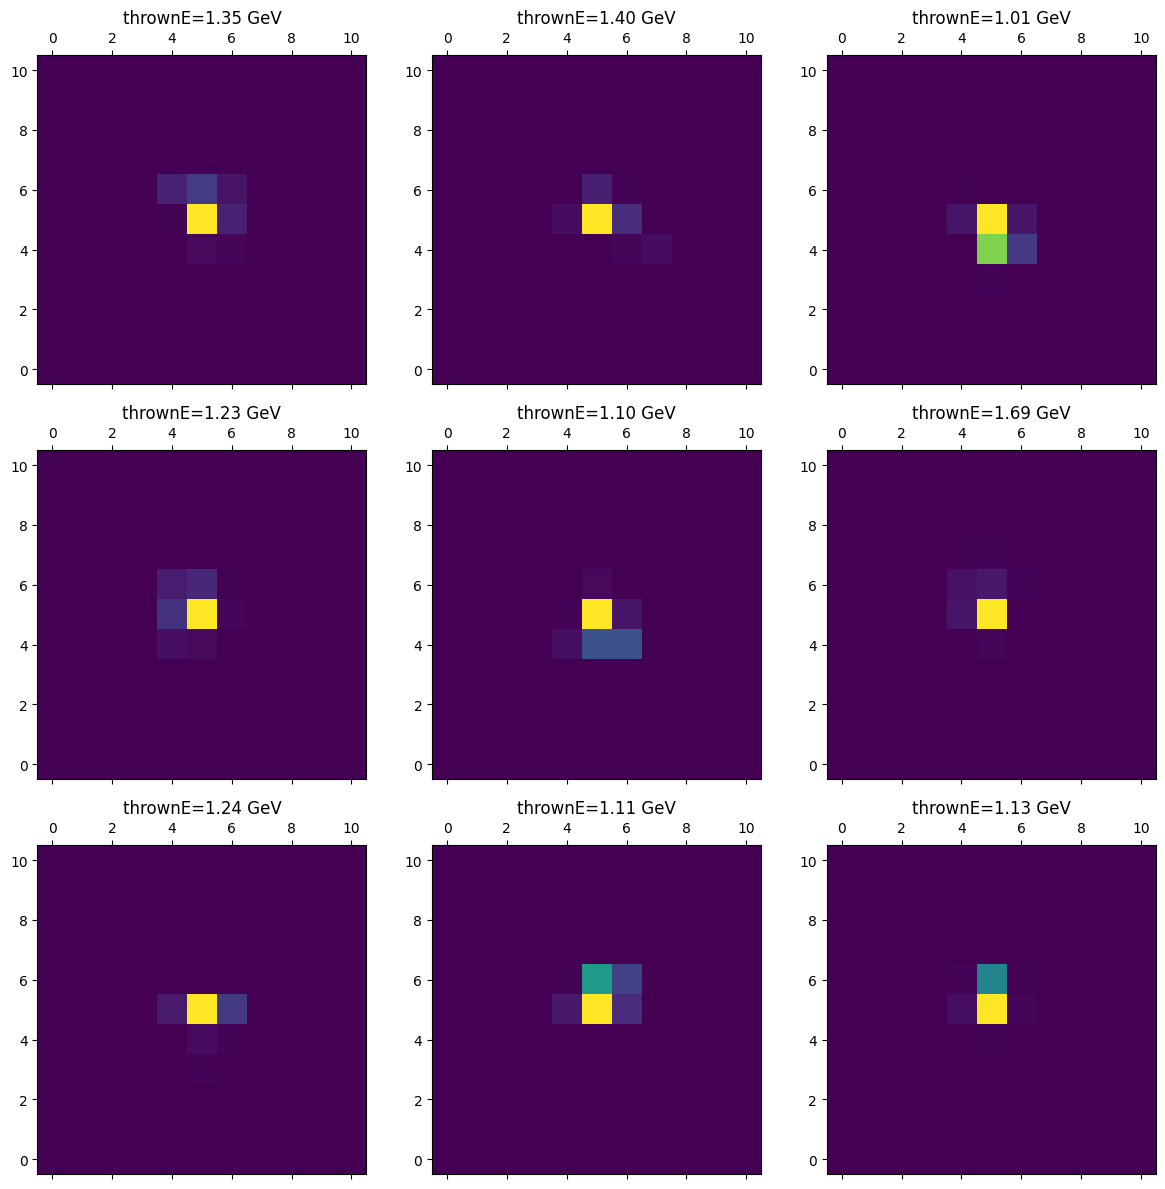

In [33]:
# lets visualize a few generated patches
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        idx = np.random.randint(0, num_gen_samples)
        axs[i, j].matshow(all_generated[idx, 0], cmap='viridis', origin='lower')
        thE = all_thrownE[idx].item() * (MAX_THROWN_E - MIN_THROWN_E) + MIN_THROWN_E
        axs[i, j].set_title(f"thrownE={thE:.2f} GeV")
plt.tight_layout()
plt.show()

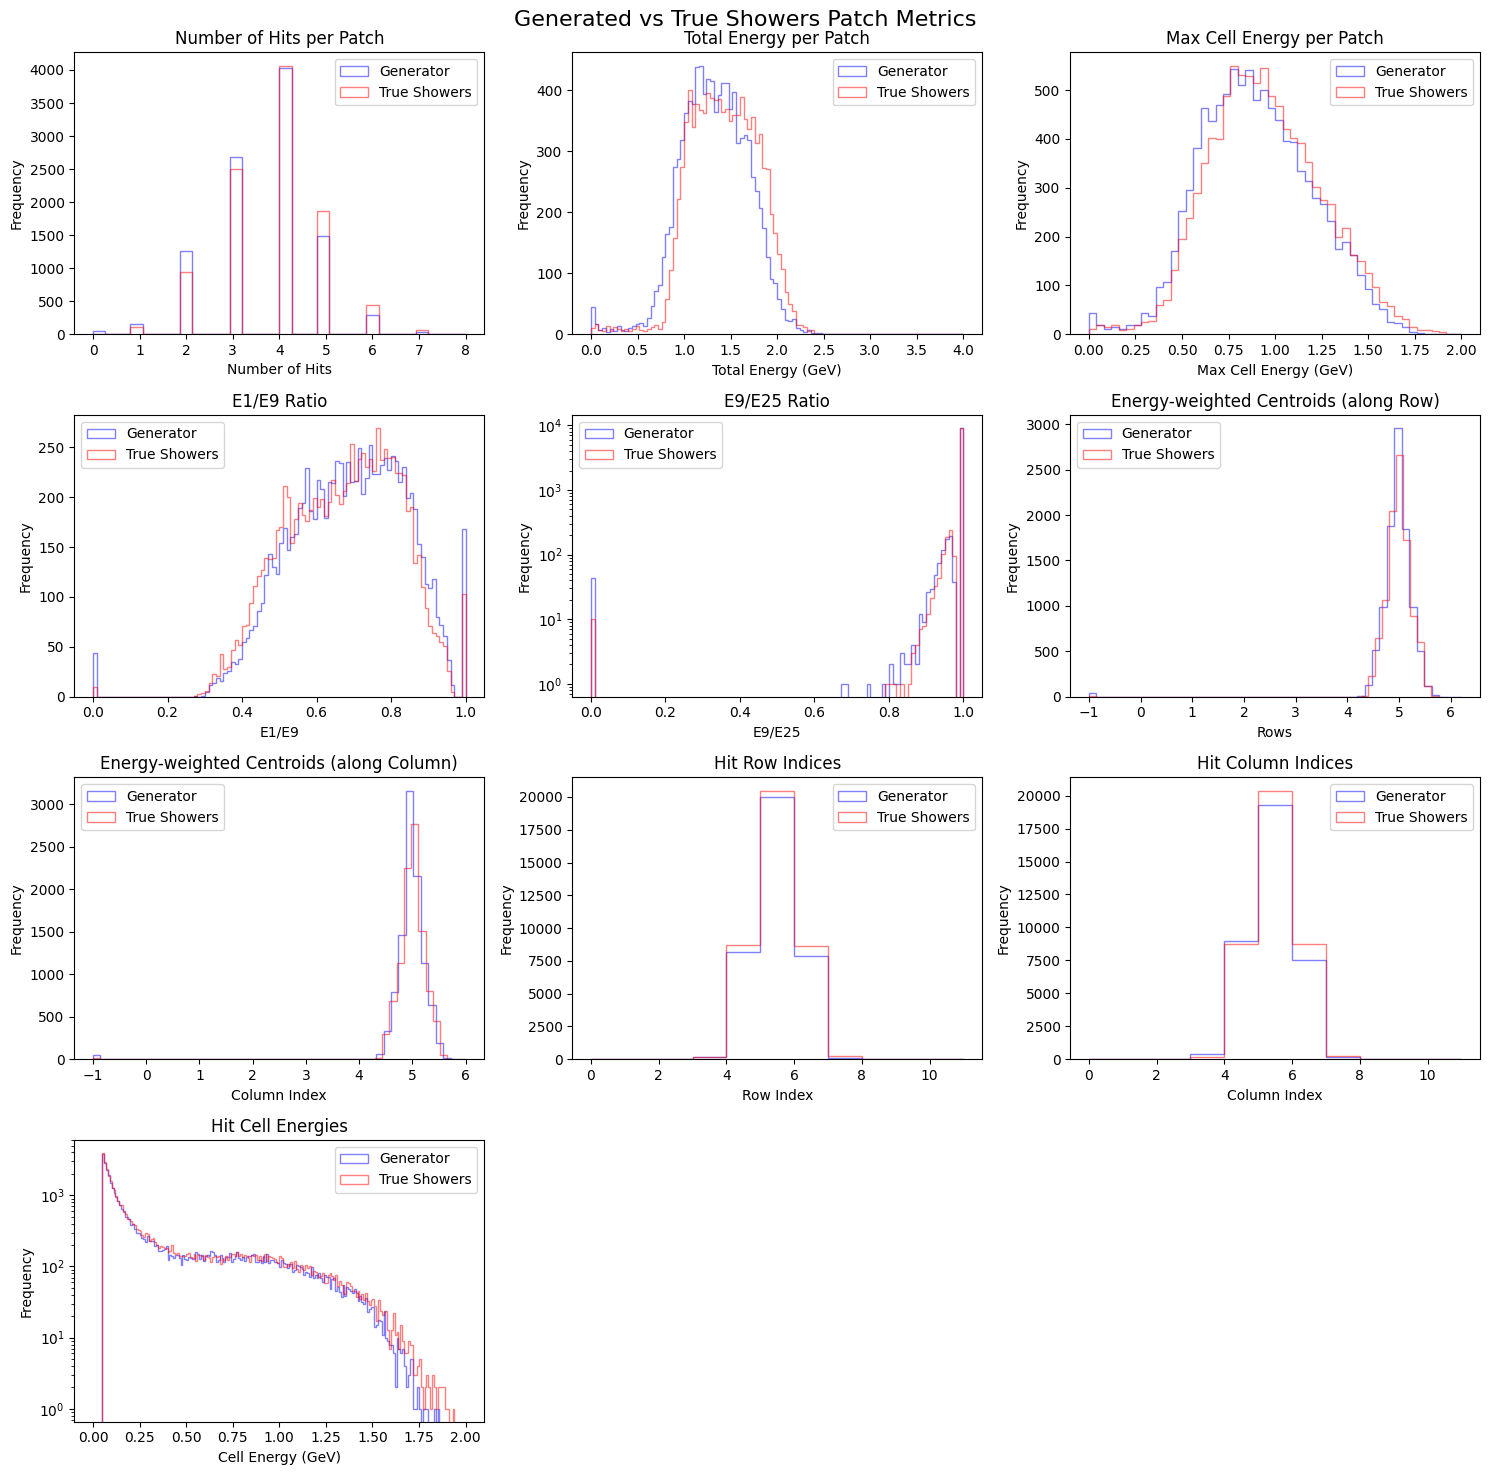

In [34]:
compare_plot(gen_metrics, true_metrics)

### Measuring Fidelity

In [ ]:
# Lets measure distribution fidelity metrics
from scipy.stats import wasserstein_distance

def compute_fidelity_metrics(real_data, generated_data):
    metrics = {}
    metrics['wasserstein_distance'] = wasserstein_distance(real_data.flatten(), generated_data.flatten())
    return metrics
fidelity_metrics = compute_fidelity_metrics(true_patches.numpy(), all_generated)
print("Fidelity Metrics between real and generated patches:")
for k, v in fidelity_metrics.items():
    print(f"{k}: {v:.6f}")



Fidelity Metrics between real and generated patches:
wasserstein_distance: 0.001032


## Conclusion

In this exercise, we successfully demonstrated a **conditional Wasserstein GAN with gradient penalty (wGAN-GP)** to build a **Fast Simulator** for calorimeter showers in the **GlueX Forward Calorimeter (FCAL)**. The model was conditioned on the thrown photon energy and trained to generate realistic hit energy maps that reproduce various physics-driven distributions.

The comparison plots show that the generated showers reproduce key observables such as:
- Total and maximum cell energy per patch  
- Energy ratios (E1/E9, E9/E25)  
- Energy-weighted centroids (row and column)  
- Hit multiplicities and cell-level energy distributions  

This demonstrates that deep generative models can serve as **learned surrogates** to replace or accelerate full detector simulations — an idea increasingly adopted in **nuclear and particle physics** (notably, the *CaloGAN* developed for calorimeter simulations at the LHC).

---

### Drawbacks of GAN-based Approaches

While GANs offer fast and high-fidelity simulation capabilities, they also come with well-known challenges:

1. **Training Instability:**  
   GAN training is a minimax optimization problem and can suffer from non-convergence or mode collapse.

2. **Mode Collapse:**  
   The generator may produce limited diversity, missing some shower morphologies or rare features.

3. **Difficulty in Quantitative Evaluation:**  
   Metrics like Inception Score or FID are not always physically meaningful in detector simulation contexts.

4. **Hyperparameter Sensitivity:**  
   Performance can vary greatly depending on architecture, batch size, learning rate, and regularization strength.

5. **Physics Constraints Not Explicitly Enforced:**  
   The model learns correlations implicitly; enforcing physics priors or conservation laws requires special architectures or loss functions.

---

### Try Next

Here are a few directions to extend this work:

1. **Expand Kinematic Range:**  
   Train over the full photon energy range (e.g., 0.1–8 GeV) and check model stability and fidelity at high and low ends.

2. **Condition on More Features:**  
   Include the photon’s **polar (θ)** and **azimuthal (φ)** angles as conditioning inputs to model spatial dependence in shower development.

3. **Tune Model Hyperparameters:**  
   Experiment with:
   - Number of convolutional layers and filters  
   - Learning rate and optimizer  
   - Gradient penalty coefficient (λ)  
   - Batch size and normalization schemes  

4. **Evaluate Physics Fidelity:**  
   Compare reconstructed quantities (like π⁰ or ω invariant masses) using generated vs. simulated showers.

5. **Deploy as a Fast Simulation Module:**  
   Integrate the trained generator into a GlueX simulation pipeline as a drop-in surrogate for Geant4-level calorimeter simulation.

---

By completing this exercise, you’ve seen how **generative AI** can be used to **accelerate detector simulations** while retaining physics fidelity — a powerful tool for next-generation analyses in **nuclear and particle physics**.


### Alternatives and Future Directions

Several alternative generative approaches address these limitations and are worth exploring:

- **Variational Autoencoders (VAEs):**  
  Offer stable training and explicit latent-space structure, though sometimes at the cost of sample sharpness.

- **Normalizing Flows:**  
  Provide exact likelihoods and allow density estimation, useful for physically interpretable generation.

- **Diffusion Models:**  
  Recently shown to outperform GANs in both fidelity and stability, with the potential to model fine shower details.

- **Physics-Informed Generative Models:**  
  Incorporate known detector response or conservation laws directly into the architecture or loss function.

---

